<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[20:53:53] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


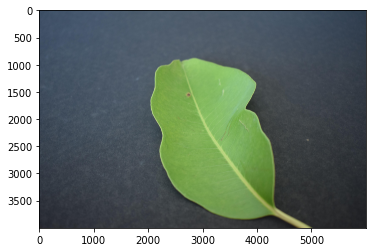

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

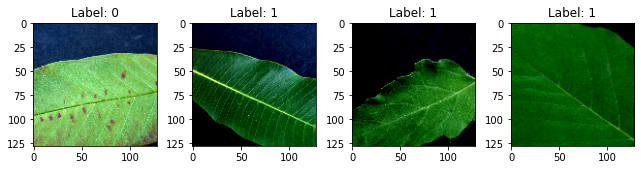

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[20:53:58] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[20:54:00] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2546759766409068 samples/sec                   batch loss = 1.253859043121338 | accuracy = 0.85


Epoch[1] Batch[10] Speed: 1.268702649706989 samples/sec                   batch loss = 1.0525318384170532 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2615829221605013 samples/sec                   batch loss = 0.3622511625289917 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2582361207138157 samples/sec                   batch loss = 0.428062379360199 | accuracy = 0.675


Epoch[1] Batch[25] Speed: 1.2622238793854041 samples/sec                   batch loss = 1.4420382976531982 | accuracy = 0.64


Epoch[1] Batch[30] Speed: 1.2672719763145484 samples/sec                   batch loss = 0.6551422476768494 | accuracy = 0.65


Epoch[1] Batch[35] Speed: 1.2607276191604084 samples/sec                   batch loss = 1.2593185901641846 | accuracy = 0.6571428571428571


Epoch[1] Batch[40] Speed: 1.2666848874063985 samples/sec                   batch loss = 0.24617651104927063 | accuracy = 0.65625


Epoch[1] Batch[45] Speed: 1.2630431789281609 samples/sec                   batch loss = 0.6890887022018433 | accuracy = 0.65


Epoch[1] Batch[50] Speed: 1.2621823820656703 samples/sec                   batch loss = 0.6028916239738464 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2599345956898882 samples/sec                   batch loss = 1.2864917516708374 | accuracy = 0.6363636363636364


Epoch[1] Batch[60] Speed: 1.2638267929487854 samples/sec                   batch loss = 0.6936126947402954 | accuracy = 0.6333333333333333


Epoch[1] Batch[65] Speed: 1.2597415089056654 samples/sec                   batch loss = 0.2647022008895874 | accuracy = 0.65


Epoch[1] Batch[70] Speed: 1.2582853804301155 samples/sec                   batch loss = 0.39613398909568787 | accuracy = 0.6535714285714286


Epoch[1] Batch[75] Speed: 1.262537238988442 samples/sec                   batch loss = 0.3255639374256134 | accuracy = 0.67


Epoch[1] Batch[80] Speed: 1.2615683129280777 samples/sec                   batch loss = 0.5643810629844666 | accuracy = 0.671875


Epoch[1] Batch[85] Speed: 1.2227854836088214 samples/sec                   batch loss = 0.4455297887325287 | accuracy = 0.6676470588235294


Epoch[1] Batch[90] Speed: 1.2681893864565588 samples/sec                   batch loss = 0.5757337212562561 | accuracy = 0.6694444444444444


Epoch[1] Batch[95] Speed: 1.2668774301106391 samples/sec                   batch loss = 0.307100772857666 | accuracy = 0.6815789473684211


Epoch[1] Batch[100] Speed: 1.2727921850033523 samples/sec                   batch loss = 0.16025760769844055 | accuracy = 0.685


Epoch[1] Batch[105] Speed: 1.2631805931217965 samples/sec                   batch loss = 0.20588929951190948 | accuracy = 0.6761904761904762


Epoch[1] Batch[110] Speed: 1.2664668769239829 samples/sec                   batch loss = 0.3744059205055237 | accuracy = 0.6772727272727272


Epoch[1] Batch[115] Speed: 1.272524192211254 samples/sec                   batch loss = 0.28198885917663574 | accuracy = 0.6826086956521739


Epoch[1] Batch[120] Speed: 1.2676723238060539 samples/sec                   batch loss = 0.7773833870887756 | accuracy = 0.6854166666666667


Epoch[1] Batch[125] Speed: 1.264740650089583 samples/sec                   batch loss = 0.6423143744468689 | accuracy = 0.682


Epoch[1] Batch[130] Speed: 1.2651810915588841 samples/sec                   batch loss = 0.43688690662384033 | accuracy = 0.6826923076923077


Epoch[1] Batch[135] Speed: 1.2650449587736528 samples/sec                   batch loss = 0.7911540269851685 | accuracy = 0.687037037037037


Epoch[1] Batch[140] Speed: 1.2668885272514203 samples/sec                   batch loss = 0.7305160760879517 | accuracy = 0.6857142857142857


Epoch[1] Batch[145] Speed: 1.2733531532749998 samples/sec                   batch loss = 0.7428913116455078 | accuracy = 0.6844827586206896


Epoch[1] Batch[150] Speed: 1.26622619639363 samples/sec                   batch loss = 0.5263937711715698 | accuracy = 0.6816666666666666


Epoch[1] Batch[155] Speed: 1.2661233758971309 samples/sec                   batch loss = 0.40153688192367554 | accuracy = 0.6790322580645162


Epoch[1] Batch[160] Speed: 1.267408493106435 samples/sec                   batch loss = 0.7902120351791382 | accuracy = 0.6765625


Epoch[1] Batch[165] Speed: 1.2650242599982342 samples/sec                   batch loss = 0.8826802968978882 | accuracy = 0.6742424242424242


Epoch[1] Batch[170] Speed: 1.268505619512642 samples/sec                   batch loss = 0.5120020508766174 | accuracy = 0.6779411764705883


Epoch[1] Batch[175] Speed: 1.2647334041591003 samples/sec                   batch loss = 0.5661767721176147 | accuracy = 0.6785714285714286


Epoch[1] Batch[180] Speed: 1.2656818962970473 samples/sec                   batch loss = 0.663365364074707 | accuracy = 0.6777777777777778


Epoch[1] Batch[185] Speed: 1.2672941846169372 samples/sec                   batch loss = 0.21758975088596344 | accuracy = 0.6837837837837838


Epoch[1] Batch[190] Speed: 1.2628564576658736 samples/sec                   batch loss = 0.5639585852622986 | accuracy = 0.6855263157894737


Epoch[1] Batch[195] Speed: 1.2608902099452497 samples/sec                   batch loss = 0.9426897764205933 | accuracy = 0.6846153846153846


Epoch[1] Batch[200] Speed: 1.2595908458347322 samples/sec                   batch loss = 0.4038797914981842 | accuracy = 0.6875


Epoch[1] Batch[205] Speed: 1.2583258668776325 samples/sec                   batch loss = 0.4865330755710602 | accuracy = 0.6890243902439024


Epoch[1] Batch[210] Speed: 1.2665201295748836 samples/sec                   batch loss = 0.6519091725349426 | accuracy = 0.6904761904761905


Epoch[1] Batch[215] Speed: 1.2656623224412236 samples/sec                   batch loss = 0.5727802515029907 | accuracy = 0.686046511627907


Epoch[1] Batch[220] Speed: 1.2713433190507022 samples/sec                   batch loss = 1.2389391660690308 | accuracy = 0.6863636363636364


Epoch[1] Batch[225] Speed: 1.2707889326063335 samples/sec                   batch loss = 0.5679820775985718 | accuracy = 0.6888888888888889


Epoch[1] Batch[230] Speed: 1.2733517036068245 samples/sec                   batch loss = 0.507853627204895 | accuracy = 0.6923913043478261


Epoch[1] Batch[235] Speed: 1.2637694827364774 samples/sec                   batch loss = 0.46861881017684937 | accuracy = 0.6968085106382979


Epoch[1] Batch[240] Speed: 1.264735692338704 samples/sec                   batch loss = 0.46967393159866333 | accuracy = 0.6979166666666666


Epoch[1] Batch[245] Speed: 1.2671524286120952 samples/sec                   batch loss = 0.4355793297290802 | accuracy = 0.7


Epoch[1] Batch[250] Speed: 1.2692770146855812 samples/sec                   batch loss = 0.35536661744117737 | accuracy = 0.699


Epoch[1] Batch[255] Speed: 1.2671909034735025 samples/sec                   batch loss = 0.5153234004974365 | accuracy = 0.7


Epoch[1] Batch[260] Speed: 1.272166304428351 samples/sec                   batch loss = 0.6567659378051758 | accuracy = 0.6971153846153846


Epoch[1] Batch[265] Speed: 1.265449627086745 samples/sec                   batch loss = 0.16589991748332977 | accuracy = 0.6971698113207547


Epoch[1] Batch[270] Speed: 1.2722730996835927 samples/sec                   batch loss = 0.8761601448059082 | accuracy = 0.6972222222222222


Epoch[1] Batch[275] Speed: 1.271550387027003 samples/sec                   batch loss = 0.15642131865024567 | accuracy = 0.6981818181818182


Epoch[1] Batch[280] Speed: 1.2676424398232713 samples/sec                   batch loss = 0.4054067134857178 | accuracy = 0.6973214285714285


Epoch[1] Batch[285] Speed: 1.2721769156207317 samples/sec                   batch loss = 0.41804221272468567 | accuracy = 0.6964912280701754


Epoch[1] Batch[290] Speed: 1.2676221348440335 samples/sec                   batch loss = 0.5714489221572876 | accuracy = 0.6974137931034483


Epoch[1] Batch[295] Speed: 1.2702410883063233 samples/sec                   batch loss = 0.8469797372817993 | accuracy = 0.6974576271186441


Epoch[1] Batch[300] Speed: 1.2721200031148607 samples/sec                   batch loss = 0.8697489500045776 | accuracy = 0.6958333333333333


Epoch[1] Batch[305] Speed: 1.2751037618762793 samples/sec                   batch loss = 0.7071617841720581 | accuracy = 0.6983606557377049


Epoch[1] Batch[310] Speed: 1.2697595412001659 samples/sec                   batch loss = 1.1038159132003784 | accuracy = 0.7008064516129032


Epoch[1] Batch[315] Speed: 1.2665233803305571 samples/sec                   batch loss = 1.1417453289031982 | accuracy = 0.6992063492063492


Epoch[1] Batch[320] Speed: 1.2673155321240372 samples/sec                   batch loss = 0.5553829073905945 | accuracy = 0.69921875


Epoch[1] Batch[325] Speed: 1.265867066278232 samples/sec                   batch loss = 0.40553179383277893 | accuracy = 0.7007692307692308


Epoch[1] Batch[330] Speed: 1.2616258031603331 samples/sec                   batch loss = 0.3055086135864258 | accuracy = 0.7


Epoch[1] Batch[335] Speed: 1.2629689211416786 samples/sec                   batch loss = 0.9470036625862122 | accuracy = 0.6985074626865672


Epoch[1] Batch[340] Speed: 1.2669760675478268 samples/sec                   batch loss = 0.340914785861969 | accuracy = 0.6977941176470588


Epoch[1] Batch[345] Speed: 1.2641914342619875 samples/sec                   batch loss = 0.310433030128479 | accuracy = 0.6942028985507246


Epoch[1] Batch[350] Speed: 1.2642419235219216 samples/sec                   batch loss = 0.6306007504463196 | accuracy = 0.6942857142857143


Epoch[1] Batch[355] Speed: 1.2585292822769747 samples/sec                   batch loss = 0.5181809663772583 | accuracy = 0.6929577464788732


Epoch[1] Batch[360] Speed: 1.2661853910939491 samples/sec                   batch loss = 1.2184741497039795 | accuracy = 0.6916666666666667


Epoch[1] Batch[365] Speed: 1.2630423231548955 samples/sec                   batch loss = 0.4641841650009155 | accuracy = 0.6931506849315069


Epoch[1] Batch[370] Speed: 1.2633528547965638 samples/sec                   batch loss = 0.5456922650337219 | accuracy = 0.6932432432432433


Epoch[1] Batch[375] Speed: 1.2614473728630877 samples/sec                   batch loss = 0.578223705291748 | accuracy = 0.6933333333333334


Epoch[1] Batch[380] Speed: 1.266833617436577 samples/sec                   batch loss = 0.43124547600746155 | accuracy = 0.6953947368421053


Epoch[1] Batch[385] Speed: 1.2660332783546262 samples/sec                   batch loss = 0.42659157514572144 | accuracy = 0.6954545454545454


Epoch[1] Batch[390] Speed: 1.2719895094248985 samples/sec                   batch loss = 0.8012884855270386 | accuracy = 0.6942307692307692


Epoch[1] Batch[395] Speed: 1.2663682231641633 samples/sec                   batch loss = 0.5337291955947876 | accuracy = 0.6943037974683545


Epoch[1] Batch[400] Speed: 1.2659372712276242 samples/sec                   batch loss = 1.2382981777191162 | accuracy = 0.693125


Epoch[1] Batch[405] Speed: 1.2637217916552803 samples/sec                   batch loss = 0.6050904393196106 | accuracy = 0.6944444444444444


Epoch[1] Batch[410] Speed: 1.2714583591949045 samples/sec                   batch loss = 0.47965848445892334 | accuracy = 0.6939024390243902


Epoch[1] Batch[415] Speed: 1.2618665411109202 samples/sec                   batch loss = 0.32911714911460876 | accuracy = 0.694578313253012


Epoch[1] Batch[420] Speed: 1.2670352956582793 samples/sec                   batch loss = 0.3158928453922272 | accuracy = 0.6964285714285714


Epoch[1] Batch[425] Speed: 1.2674280252627177 samples/sec                   batch loss = 0.5455152988433838 | accuracy = 0.6958823529411765


Epoch[1] Batch[430] Speed: 1.2661785108341508 samples/sec                   batch loss = 0.7788355350494385 | accuracy = 0.6953488372093023


Epoch[1] Batch[435] Speed: 1.264593745538703 samples/sec                   batch loss = 0.6393407583236694 | accuracy = 0.6948275862068966


Epoch[1] Batch[440] Speed: 1.2681466332640776 samples/sec                   batch loss = 0.436455637216568 | accuracy = 0.6954545454545454


Epoch[1] Batch[445] Speed: 1.2637662461021444 samples/sec                   batch loss = 0.704720675945282 | accuracy = 0.6938202247191011


Epoch[1] Batch[450] Speed: 1.2652815643224906 samples/sec                   batch loss = 0.6364280581474304 | accuracy = 0.6938888888888889


Epoch[1] Batch[455] Speed: 1.2650246415363537 samples/sec                   batch loss = 0.8436629772186279 | accuracy = 0.6928571428571428


Epoch[1] Batch[460] Speed: 1.267885767056479 samples/sec                   batch loss = 0.397352397441864 | accuracy = 0.6951086956521739


Epoch[1] Batch[465] Speed: 1.2707923015686058 samples/sec                   batch loss = 0.5783440470695496 | accuracy = 0.6946236559139785


Epoch[1] Batch[470] Speed: 1.2657959141053434 samples/sec                   batch loss = 0.37351253628730774 | accuracy = 0.6952127659574469


Epoch[1] Batch[475] Speed: 1.2629183433723647 samples/sec                   batch loss = 0.3431354761123657 | accuracy = 0.6947368421052632


Epoch[1] Batch[480] Speed: 1.2701348262139978 samples/sec                   batch loss = 0.461006224155426 | accuracy = 0.6927083333333334


Epoch[1] Batch[485] Speed: 1.268404346404426 samples/sec                   batch loss = 0.40225040912628174 | accuracy = 0.6938144329896907


Epoch[1] Batch[490] Speed: 1.265757332916072 samples/sec                   batch loss = 0.3524172306060791 | accuracy = 0.6954081632653061


Epoch[1] Batch[495] Speed: 1.2660381507463243 samples/sec                   batch loss = 1.0224189758300781 | accuracy = 0.6944444444444444


Epoch[1] Batch[500] Speed: 1.2647805995391455 samples/sec                   batch loss = 0.5259373784065247 | accuracy = 0.6945


Epoch[1] Batch[505] Speed: 1.2635647506651384 samples/sec                   batch loss = 0.36556723713874817 | accuracy = 0.694059405940594


Epoch[1] Batch[510] Speed: 1.2586405042059297 samples/sec                   batch loss = 0.9768157005310059 | accuracy = 0.6936274509803921


Epoch[1] Batch[515] Speed: 1.2663927895721894 samples/sec                   batch loss = 0.5759753584861755 | accuracy = 0.6941747572815534


Epoch[1] Batch[520] Speed: 1.2662278210150357 samples/sec                   batch loss = 0.400511771440506 | accuracy = 0.6951923076923077


Epoch[1] Batch[525] Speed: 1.2605648808756353 samples/sec                   batch loss = 0.34618303179740906 | accuracy = 0.6961904761904761


Epoch[1] Batch[530] Speed: 1.269660469902275 samples/sec                   batch loss = 0.8402406573295593 | accuracy = 0.6957547169811321


Epoch[1] Batch[535] Speed: 1.2685637437702089 samples/sec                   batch loss = 1.879256248474121 | accuracy = 0.6953271028037383


Epoch[1] Batch[540] Speed: 1.267461250460551 samples/sec                   batch loss = 0.7046605944633484 | accuracy = 0.6930555555555555


Epoch[1] Batch[545] Speed: 1.2666925382600096 samples/sec                   batch loss = 0.5389361381530762 | accuracy = 0.6926605504587156


Epoch[1] Batch[550] Speed: 1.2642296342552464 samples/sec                   batch loss = 0.32617610692977905 | accuracy = 0.6927272727272727


Epoch[1] Batch[555] Speed: 1.2663135495994222 samples/sec                   batch loss = 0.6273218989372253 | accuracy = 0.6927927927927928


Epoch[1] Batch[560] Speed: 1.2661509905426673 samples/sec                   batch loss = 0.33824092149734497 | accuracy = 0.6924107142857143


Epoch[1] Batch[565] Speed: 1.2708640165739684 samples/sec                   batch loss = 0.6872231364250183 | accuracy = 0.6924778761061947


Epoch[1] Batch[570] Speed: 1.276628824092142 samples/sec                   batch loss = 0.7811505794525146 | accuracy = 0.6921052631578948


Epoch[1] Batch[575] Speed: 1.270695763813744 samples/sec                   batch loss = 0.7299973964691162 | accuracy = 0.6908695652173913


Epoch[1] Batch[580] Speed: 1.2683237039141462 samples/sec                   batch loss = 0.2820028066635132 | accuracy = 0.6922413793103448


Epoch[1] Batch[585] Speed: 1.2656222217980988 samples/sec                   batch loss = 0.4874515235424042 | accuracy = 0.6927350427350427


Epoch[1] Batch[590] Speed: 1.2675753975524482 samples/sec                   batch loss = 0.7966640591621399 | accuracy = 0.6927966101694916


Epoch[1] Batch[595] Speed: 1.2722074961380048 samples/sec                   batch loss = 0.713537335395813 | accuracy = 0.692436974789916


Epoch[1] Batch[600] Speed: 1.2702714796492287 samples/sec                   batch loss = 0.8607344627380371 | accuracy = 0.6933333333333334


Epoch[1] Batch[605] Speed: 1.2695183761875712 samples/sec                   batch loss = 0.6465165615081787 | accuracy = 0.6933884297520662


Epoch[1] Batch[610] Speed: 1.2716536089575652 samples/sec                   batch loss = 0.7661077976226807 | accuracy = 0.6930327868852459


Epoch[1] Batch[615] Speed: 1.2732459833731105 samples/sec                   batch loss = 0.6479515433311462 | accuracy = 0.6922764227642276


Epoch[1] Batch[620] Speed: 1.268334251100489 samples/sec                   batch loss = 0.9132309556007385 | accuracy = 0.6919354838709677


Epoch[1] Batch[625] Speed: 1.2719096639630185 samples/sec                   batch loss = 0.510820746421814 | accuracy = 0.692


Epoch[1] Batch[630] Speed: 1.2741109114571527 samples/sec                   batch loss = 0.4775558412075043 | accuracy = 0.692063492063492


Epoch[1] Batch[635] Speed: 1.2689078026350014 samples/sec                   batch loss = 0.2572404146194458 | accuracy = 0.6933070866141732


Epoch[1] Batch[640] Speed: 1.2693450053766968 samples/sec                   batch loss = 0.7279992699623108 | accuracy = 0.693359375


Epoch[1] Batch[645] Speed: 1.2746582258842776 samples/sec                   batch loss = 0.4877529442310333 | accuracy = 0.6937984496124031


Epoch[1] Batch[650] Speed: 1.2775609066674465 samples/sec                   batch loss = 0.3563550114631653 | accuracy = 0.6938461538461539


Epoch[1] Batch[655] Speed: 1.2670030496190279 samples/sec                   batch loss = 0.5955808162689209 | accuracy = 0.6946564885496184


Epoch[1] Batch[660] Speed: 1.2700855958689174 samples/sec                   batch loss = 0.4265553951263428 | accuracy = 0.6950757575757576


Epoch[1] Batch[665] Speed: 1.2737121927314234 samples/sec                   batch loss = 0.4854090213775635 | accuracy = 0.6962406015037594


Epoch[1] Batch[670] Speed: 1.2652109550157198 samples/sec                   batch loss = 0.6208334565162659 | accuracy = 0.6962686567164179


Epoch[1] Batch[675] Speed: 1.2738607399686372 samples/sec                   batch loss = 0.3631679117679596 | accuracy = 0.6966666666666667


Epoch[1] Batch[680] Speed: 1.2725964889471673 samples/sec                   batch loss = 0.3183484673500061 | accuracy = 0.6970588235294117


Epoch[1] Batch[685] Speed: 1.2652522700454156 samples/sec                   batch loss = 0.38051795959472656 | accuracy = 0.6970802919708029


Epoch[1] Batch[690] Speed: 1.2586352164705419 samples/sec                   batch loss = 0.4663553237915039 | accuracy = 0.697463768115942


Epoch[1] Batch[695] Speed: 1.2672094717797813 samples/sec                   batch loss = 0.3627508878707886 | accuracy = 0.6974820143884892


Epoch[1] Batch[700] Speed: 1.2702940817490385 samples/sec                   batch loss = 0.3455694913864136 | accuracy = 0.6982142857142857


Epoch[1] Batch[705] Speed: 1.2646844962999202 samples/sec                   batch loss = 0.6535754799842834 | accuracy = 0.6978723404255319


Epoch[1] Batch[710] Speed: 1.2654770214447206 samples/sec                   batch loss = 0.7588856816291809 | accuracy = 0.6982394366197183


Epoch[1] Batch[715] Speed: 1.2651333892809131 samples/sec                   batch loss = 0.24931980669498444 | accuracy = 0.6996503496503497


Epoch[1] Batch[720] Speed: 1.2709936054170585 samples/sec                   batch loss = 0.23137634992599487 | accuracy = 0.7


Epoch[1] Batch[725] Speed: 1.2719821801965454 samples/sec                   batch loss = 0.5029664635658264 | accuracy = 0.7


Epoch[1] Batch[730] Speed: 1.2704142230040831 samples/sec                   batch loss = 0.2453472763299942 | accuracy = 0.6996575342465754


Epoch[1] Batch[735] Speed: 1.2746451522321691 samples/sec                   batch loss = 0.6688295006752014 | accuracy = 0.6989795918367347


Epoch[1] Batch[740] Speed: 1.2667707735424774 samples/sec                   batch loss = 0.5393957495689392 | accuracy = 0.6996621621621621


Epoch[1] Batch[745] Speed: 1.271122835465242 samples/sec                   batch loss = 1.0838624238967896 | accuracy = 0.6989932885906041


Epoch[1] Batch[750] Speed: 1.269678053688898 samples/sec                   batch loss = 0.4900764226913452 | accuracy = 0.6986666666666667


Epoch[1] Batch[755] Speed: 1.2752783217106403 samples/sec                   batch loss = 0.8305110335350037 | accuracy = 0.6983443708609272


Epoch[1] Batch[760] Speed: 1.266935979287672 samples/sec                   batch loss = 0.25220778584480286 | accuracy = 0.6980263157894737


Epoch[1] Batch[765] Speed: 1.2694174215518532 samples/sec                   batch loss = 0.5312338471412659 | accuracy = 0.6990196078431372


Epoch[1] Batch[770] Speed: 1.2723391924492717 samples/sec                   batch loss = 0.9871934652328491 | accuracy = 0.6983766233766234


Epoch[1] Batch[775] Speed: 1.2722724243185104 samples/sec                   batch loss = 0.3976340889930725 | accuracy = 0.697741935483871


Epoch[1] Batch[780] Speed: 1.2708909719573567 samples/sec                   batch loss = 0.573309063911438 | accuracy = 0.6977564102564102


Epoch[1] Batch[785] Speed: 1.2684276492951951 samples/sec                   batch loss = 0.4633289873600006 | accuracy = 0.6984076433121019


[Epoch 1] training: accuracy=0.6986040609137056
[Epoch 1] time cost: 648.7735078334808
[Epoch 1] validation: validation accuracy=0.7011111111111111


Epoch[2] Batch[5] Speed: 1.2766753570585267 samples/sec                   batch loss = 0.39027583599090576 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2702682096247946 samples/sec                   batch loss = 0.22717806696891785 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2756094478887898 samples/sec                   batch loss = 0.21666459739208221 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2691180140499094 samples/sec                   batch loss = 0.2204102873802185 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2692742299114235 samples/sec                   batch loss = 0.1519135683774948 | accuracy = 0.83


Epoch[2] Batch[30] Speed: 1.2674212272380627 samples/sec                   batch loss = 0.1915614753961563 | accuracy = 0.8333333333333334


Epoch[2] Batch[35] Speed: 1.2721296489439002 samples/sec                   batch loss = 0.3893371820449829 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2690886378581128 samples/sec                   batch loss = 0.3009428381919861 | accuracy = 0.8125


Epoch[2] Batch[45] Speed: 1.2712154889744673 samples/sec                   batch loss = 0.5520387291908264 | accuracy = 0.8055555555555556


Epoch[2] Batch[50] Speed: 1.2678805929859454 samples/sec                   batch loss = 0.4871014654636383 | accuracy = 0.805


Epoch[2] Batch[55] Speed: 1.270186752978999 samples/sec                   batch loss = 1.522061824798584 | accuracy = 0.8


Epoch[2] Batch[60] Speed: 1.2705538231689326 samples/sec                   batch loss = 0.3859826922416687 | accuracy = 0.8041666666666667


Epoch[2] Batch[65] Speed: 1.2683536200268015 samples/sec                   batch loss = 0.6467175483703613 | accuracy = 0.8038461538461539


Epoch[2] Batch[70] Speed: 1.2668612630724323 samples/sec                   batch loss = 0.44423365592956543 | accuracy = 0.7928571428571428


Epoch[2] Batch[75] Speed: 1.2685453275873866 samples/sec                   batch loss = 0.3384982645511627 | accuracy = 0.79


Epoch[2] Batch[80] Speed: 1.2648124464928725 samples/sec                   batch loss = 0.5766052007675171 | accuracy = 0.790625


Epoch[2] Batch[85] Speed: 1.270850635576209 samples/sec                   batch loss = 0.7739185094833374 | accuracy = 0.788235294117647


Epoch[2] Batch[90] Speed: 1.2655983535740718 samples/sec                   batch loss = 0.3214147090911865 | accuracy = 0.7888888888888889


Epoch[2] Batch[95] Speed: 1.2710770915718301 samples/sec                   batch loss = 0.45459431409835815 | accuracy = 0.7868421052631579


Epoch[2] Batch[100] Speed: 1.275187304262751 samples/sec                   batch loss = 0.2687881886959076 | accuracy = 0.79


Epoch[2] Batch[105] Speed: 1.2691145579567586 samples/sec                   batch loss = 0.28166812658309937 | accuracy = 0.7928571428571428


Epoch[2] Batch[110] Speed: 1.2709288076921679 samples/sec                   batch loss = 0.5955420732498169 | accuracy = 0.7886363636363637


Epoch[2] Batch[115] Speed: 1.2705714317088954 samples/sec                   batch loss = 0.6980770826339722 | accuracy = 0.7804347826086957


Epoch[2] Batch[120] Speed: 1.2741590028499419 samples/sec                   batch loss = 0.42404428124427795 | accuracy = 0.7791666666666667


Epoch[2] Batch[125] Speed: 1.2658949562918365 samples/sec                   batch loss = 0.6034483909606934 | accuracy = 0.778


Epoch[2] Batch[130] Speed: 1.270028101195796 samples/sec                   batch loss = 0.5023378133773804 | accuracy = 0.7769230769230769


Epoch[2] Batch[135] Speed: 1.2665529247280007 samples/sec                   batch loss = 0.6518596410751343 | accuracy = 0.7759259259259259


Epoch[2] Batch[140] Speed: 1.2687860270621458 samples/sec                   batch loss = 0.45030859112739563 | accuracy = 0.7732142857142857


Epoch[2] Batch[145] Speed: 1.2712172227447436 samples/sec                   batch loss = 0.21894976496696472 | accuracy = 0.7741379310344828


Epoch[2] Batch[150] Speed: 1.269106877817149 samples/sec                   batch loss = 1.1207083463668823 | accuracy = 0.77


Epoch[2] Batch[155] Speed: 1.2736722572291377 samples/sec                   batch loss = 1.0422861576080322 | accuracy = 0.7645161290322581


Epoch[2] Batch[160] Speed: 1.2677737674483838 samples/sec                   batch loss = 0.5279891490936279 | accuracy = 0.76875


Epoch[2] Batch[165] Speed: 1.2752196774572613 samples/sec                   batch loss = 0.5427691340446472 | accuracy = 0.7712121212121212


Epoch[2] Batch[170] Speed: 1.2699302376208186 samples/sec                   batch loss = 0.6349308490753174 | accuracy = 0.7661764705882353


Epoch[2] Batch[175] Speed: 1.2712342717376974 samples/sec                   batch loss = 0.6275956034660339 | accuracy = 0.7642857142857142


Epoch[2] Batch[180] Speed: 1.2703246679987854 samples/sec                   batch loss = 0.49099284410476685 | accuracy = 0.7611111111111111


Epoch[2] Batch[185] Speed: 1.2635414357854398 samples/sec                   batch loss = 0.06783054023981094 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2651607699486673 samples/sec                   batch loss = 0.7646101117134094 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2667972686097386 samples/sec                   batch loss = 0.1277763992547989 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2642379223390987 samples/sec                   batch loss = 0.6742933392524719 | accuracy = 0.755


Epoch[2] Batch[205] Speed: 1.2664068416037333 samples/sec                   batch loss = 0.15029264986515045 | accuracy = 0.7548780487804878


Epoch[2] Batch[210] Speed: 1.2707447527256621 samples/sec                   batch loss = 0.695247232913971 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2748719939221524 samples/sec                   batch loss = 0.7451208233833313 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2708833665726753 samples/sec                   batch loss = 0.48261067271232605 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.2727896744607499 samples/sec                   batch loss = 0.3372003138065338 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.2691556482826678 samples/sec                   batch loss = 0.33516162633895874 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.2734415892759336 samples/sec                   batch loss = 0.46396660804748535 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.2637490160631226 samples/sec                   batch loss = 0.49808719754219055 | accuracy = 0.74375


Epoch[2] Batch[245] Speed: 1.2634499926650506 samples/sec                   batch loss = 0.37767940759658813 | accuracy = 0.7448979591836735


Epoch[2] Batch[250] Speed: 1.2634028965343054 samples/sec                   batch loss = 0.3441133201122284 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.2639560932152791 samples/sec                   batch loss = 0.25829368829727173 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.264975520396101 samples/sec                   batch loss = 0.1284812092781067 | accuracy = 0.7442307692307693


Epoch[2] Batch[265] Speed: 1.2713286755679494 samples/sec                   batch loss = 0.5984297394752502 | accuracy = 0.7433962264150943


Epoch[2] Batch[270] Speed: 1.271436390122013 samples/sec                   batch loss = 0.39087367057800293 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2681451954265424 samples/sec                   batch loss = 0.605445921421051 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.2719604823182937 samples/sec                   batch loss = 0.27024513483047485 | accuracy = 0.7446428571428572


Epoch[2] Batch[285] Speed: 1.2672632655119163 samples/sec                   batch loss = 0.4675982594490051 | accuracy = 0.7464912280701754


Epoch[2] Batch[290] Speed: 1.2672119603570264 samples/sec                   batch loss = 0.7325937151908875 | accuracy = 0.7448275862068966


Epoch[2] Batch[295] Speed: 1.266489630650572 samples/sec                   batch loss = 0.20624907314777374 | accuracy = 0.7457627118644068


Epoch[2] Batch[300] Speed: 1.2677342034546275 samples/sec                   batch loss = 0.5123063921928406 | accuracy = 0.7458333333333333


Epoch[2] Batch[305] Speed: 1.2737637354711415 samples/sec                   batch loss = 0.6431372165679932 | accuracy = 0.7450819672131147


Epoch[2] Batch[310] Speed: 1.2725952340606028 samples/sec                   batch loss = 0.44119080901145935 | accuracy = 0.7435483870967742


Epoch[2] Batch[315] Speed: 1.2655442237781058 samples/sec                   batch loss = 0.47222286462783813 | accuracy = 0.7444444444444445


Epoch[2] Batch[320] Speed: 1.2715855634869782 samples/sec                   batch loss = 0.39114198088645935 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.2759019321106015 samples/sec                   batch loss = 0.8483724594116211 | accuracy = 0.7438461538461538


Epoch[2] Batch[330] Speed: 1.2647668696107506 samples/sec                   batch loss = 0.6769601106643677 | accuracy = 0.7431818181818182


Epoch[2] Batch[335] Speed: 1.2675795156589424 samples/sec                   batch loss = 0.3228210210800171 | accuracy = 0.7440298507462687


Epoch[2] Batch[340] Speed: 1.2753811802776018 samples/sec                   batch loss = 0.8636083006858826 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.2685988510999284 samples/sec                   batch loss = 0.6204664707183838 | accuracy = 0.7427536231884058


Epoch[2] Batch[350] Speed: 1.2758401257618288 samples/sec                   batch loss = 0.21892166137695312 | accuracy = 0.7442857142857143


Epoch[2] Batch[355] Speed: 1.2682056832752833 samples/sec                   batch loss = 0.5273179411888123 | accuracy = 0.7436619718309859


Epoch[2] Batch[360] Speed: 1.274115942982128 samples/sec                   batch loss = 0.2249467372894287 | accuracy = 0.7430555555555556


Epoch[2] Batch[365] Speed: 1.2699854162102766 samples/sec                   batch loss = 0.25240370631217957 | accuracy = 0.7452054794520548


Epoch[2] Batch[370] Speed: 1.268467448393047 samples/sec                   batch loss = 0.39395180344581604 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.2632775142584673 samples/sec                   batch loss = 0.28174009919166565 | accuracy = 0.742


Epoch[2] Batch[380] Speed: 1.2645616236530053 samples/sec                   batch loss = 0.6905530691146851 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.2635892084228053 samples/sec                   batch loss = 0.4316996932029724 | accuracy = 0.7441558441558441


Epoch[2] Batch[390] Speed: 1.262509021702429 samples/sec                   batch loss = 0.18971765041351318 | accuracy = 0.7461538461538462


Epoch[2] Batch[395] Speed: 1.2667168303328002 samples/sec                   batch loss = 0.7034115195274353 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.2643952260029323 samples/sec                   batch loss = 0.23302605748176575 | accuracy = 0.746875


Epoch[2] Batch[405] Speed: 1.2664342774212478 samples/sec                   batch loss = 0.1592411994934082 | accuracy = 0.7487654320987654


Epoch[2] Batch[410] Speed: 1.2674866253438761 samples/sec                   batch loss = 0.7060983777046204 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.2655666579641378 samples/sec                   batch loss = 0.2645881474018097 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.2697108204048688 samples/sec                   batch loss = 0.7907880544662476 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.2727188039980621 samples/sec                   batch loss = 0.13102558255195618 | accuracy = 0.75


Epoch[2] Batch[430] Speed: 1.2659370801831824 samples/sec                   batch loss = 0.2091297060251236 | accuracy = 0.7505813953488372


Epoch[2] Batch[435] Speed: 1.2628123523542074 samples/sec                   batch loss = 0.7150619626045227 | accuracy = 0.75


Epoch[2] Batch[440] Speed: 1.2720242279700098 samples/sec                   batch loss = 0.45850372314453125 | accuracy = 0.7482954545454545


Epoch[2] Batch[445] Speed: 1.267380823582211 samples/sec                   batch loss = 0.5438340306282043 | accuracy = 0.748314606741573


Epoch[2] Batch[450] Speed: 1.262547025075801 samples/sec                   batch loss = 0.7060544490814209 | accuracy = 0.7483333333333333


Epoch[2] Batch[455] Speed: 1.2702875414842691 samples/sec                   batch loss = 0.5486472249031067 | accuracy = 0.7489010989010989


Epoch[2] Batch[460] Speed: 1.265602076957754 samples/sec                   batch loss = 0.2503493130207062 | accuracy = 0.7489130434782608


Epoch[2] Batch[465] Speed: 1.2701661740864605 samples/sec                   batch loss = 0.662466824054718 | accuracy = 0.7489247311827957


Epoch[2] Batch[470] Speed: 1.2675210985111938 samples/sec                   batch loss = 0.23488165438175201 | accuracy = 0.7489361702127659


Epoch[2] Batch[475] Speed: 1.2655458466499825 samples/sec                   batch loss = 0.5765292644500732 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.269514533662019 samples/sec                   batch loss = 0.3023192286491394 | accuracy = 0.7484375


Epoch[2] Batch[485] Speed: 1.2689062671000824 samples/sec                   batch loss = 0.21239078044891357 | accuracy = 0.7489690721649485


Epoch[2] Batch[490] Speed: 1.2703659329149113 samples/sec                   batch loss = 0.6572132110595703 | accuracy = 0.7489795918367347


Epoch[2] Batch[495] Speed: 1.2697264836847129 samples/sec                   batch loss = 0.2900925278663635 | accuracy = 0.7505050505050505


Epoch[2] Batch[500] Speed: 1.2741221356828054 samples/sec                   batch loss = 0.4443216919898987 | accuracy = 0.7515


Epoch[2] Batch[505] Speed: 1.2726893574211429 samples/sec                   batch loss = 0.8821345567703247 | accuracy = 0.751980198019802


Epoch[2] Batch[510] Speed: 1.2681326384506442 samples/sec                   batch loss = 1.3187456130981445 | accuracy = 0.75


Epoch[2] Batch[515] Speed: 1.2652143898807078 samples/sec                   batch loss = 0.47182267904281616 | accuracy = 0.7504854368932039


Epoch[2] Batch[520] Speed: 1.2712893710453157 samples/sec                   batch loss = 0.5400867462158203 | accuracy = 0.7495192307692308


Epoch[2] Batch[525] Speed: 1.2682229391869342 samples/sec                   batch loss = 0.3191588222980499 | accuracy = 0.7495238095238095


Epoch[2] Batch[530] Speed: 1.2760092584585578 samples/sec                   batch loss = 0.19145788252353668 | accuracy = 0.75


Epoch[2] Batch[535] Speed: 1.2710911514496557 samples/sec                   batch loss = 0.2898173928260803 | accuracy = 0.7504672897196262


Epoch[2] Batch[540] Speed: 1.27095384020535 samples/sec                   batch loss = 0.36105260252952576 | accuracy = 0.750462962962963


Epoch[2] Batch[545] Speed: 1.2649065664746701 samples/sec                   batch loss = 0.3673173785209656 | accuracy = 0.7509174311926605


Epoch[2] Batch[550] Speed: 1.2688804514757228 samples/sec                   batch loss = 0.5789996981620789 | accuracy = 0.7504545454545455


Epoch[2] Batch[555] Speed: 1.2733016437576008 samples/sec                   batch loss = 0.4034128487110138 | accuracy = 0.7504504504504504


Epoch[2] Batch[560] Speed: 1.2715857562400654 samples/sec                   batch loss = 0.5201163291931152 | accuracy = 0.7504464285714286


Epoch[2] Batch[565] Speed: 1.268403195666573 samples/sec                   batch loss = 0.3801829516887665 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.2659416652657003 samples/sec                   batch loss = 0.5151896476745605 | accuracy = 0.7513157894736842


Epoch[2] Batch[575] Speed: 1.272813814703697 samples/sec                   batch loss = 0.36101987957954407 | accuracy = 0.7508695652173913


Epoch[2] Batch[580] Speed: 1.2644180959361204 samples/sec                   batch loss = 0.4146573841571808 | accuracy = 0.7508620689655172


Epoch[2] Batch[585] Speed: 1.2664679285487876 samples/sec                   batch loss = 0.6828469038009644 | accuracy = 0.7517094017094017


Epoch[2] Batch[590] Speed: 1.267653741933139 samples/sec                   batch loss = 0.28905442357063293 | accuracy = 0.7516949152542373


Epoch[2] Batch[595] Speed: 1.272742072584888 samples/sec                   batch loss = 0.2714644968509674 | accuracy = 0.7504201680672269


Epoch[2] Batch[600] Speed: 1.268741314712763 samples/sec                   batch loss = 0.6580779552459717 | accuracy = 0.7495833333333334


Epoch[2] Batch[605] Speed: 1.2706413895822533 samples/sec                   batch loss = 0.22109025716781616 | accuracy = 0.75


Epoch[2] Batch[610] Speed: 1.2705987595898602 samples/sec                   batch loss = 0.5436203479766846 | accuracy = 0.7495901639344262


Epoch[2] Batch[615] Speed: 1.2674487070255658 samples/sec                   batch loss = 0.35573652386665344 | accuracy = 0.75


Epoch[2] Batch[620] Speed: 1.2669296649003985 samples/sec                   batch loss = 0.4176153838634491 | accuracy = 0.75


Epoch[2] Batch[625] Speed: 1.2733143999477838 samples/sec                   batch loss = 0.5753980278968811 | accuracy = 0.75


Epoch[2] Batch[630] Speed: 1.2630303424509444 samples/sec                   batch loss = 0.36660173535346985 | accuracy = 0.7496031746031746


Epoch[2] Batch[635] Speed: 1.2628626364577134 samples/sec                   batch loss = 0.3031657934188843 | accuracy = 0.7492125984251968


Epoch[2] Batch[640] Speed: 1.2641198988385571 samples/sec                   batch loss = 0.2993919849395752 | accuracy = 0.749609375


Epoch[2] Batch[645] Speed: 1.2680911351011754 samples/sec                   batch loss = 0.5381713509559631 | accuracy = 0.75


Epoch[2] Batch[650] Speed: 1.2612352383551304 samples/sec                   batch loss = 0.4135369658470154 | accuracy = 0.7511538461538462


Epoch[2] Batch[655] Speed: 1.2726900332289424 samples/sec                   batch loss = 0.37095168232917786 | accuracy = 0.7515267175572519


Epoch[2] Batch[660] Speed: 1.2645912672342343 samples/sec                   batch loss = 0.49931254982948303 | accuracy = 0.7522727272727273


Epoch[2] Batch[665] Speed: 1.2721163377381794 samples/sec                   batch loss = 0.5476128458976746 | accuracy = 0.7518796992481203


Epoch[2] Batch[670] Speed: 1.2708974221650686 samples/sec                   batch loss = 0.4687041640281677 | accuracy = 0.7529850746268657


Epoch[2] Batch[675] Speed: 1.2674195995528394 samples/sec                   batch loss = 0.5726838111877441 | accuracy = 0.752962962962963


Epoch[2] Batch[680] Speed: 1.2646953643861787 samples/sec                   batch loss = 0.3336464762687683 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.2761897937622606 samples/sec                   batch loss = 0.6447479724884033 | accuracy = 0.7547445255474453


Epoch[2] Batch[690] Speed: 1.2674525370557193 samples/sec                   batch loss = 0.27048638463020325 | accuracy = 0.7543478260869565


Epoch[2] Batch[695] Speed: 1.269683434617102 samples/sec                   batch loss = 0.5235278606414795 | accuracy = 0.7550359712230216


Epoch[2] Batch[700] Speed: 1.2687598325352356 samples/sec                   batch loss = 0.6209222078323364 | accuracy = 0.7546428571428572


Epoch[2] Batch[705] Speed: 1.267155491202042 samples/sec                   batch loss = 0.3864944875240326 | accuracy = 0.7546099290780142


Epoch[2] Batch[710] Speed: 1.265794768095532 samples/sec                   batch loss = 0.35871976613998413 | accuracy = 0.7549295774647887


Epoch[2] Batch[715] Speed: 1.2719613502192109 samples/sec                   batch loss = 0.86044842004776 | accuracy = 0.7545454545454545


Epoch[2] Batch[720] Speed: 1.2681545893573742 samples/sec                   batch loss = 0.42903026938438416 | accuracy = 0.7541666666666667


Epoch[2] Batch[725] Speed: 1.2668695856973722 samples/sec                   batch loss = 0.41225019097328186 | accuracy = 0.7537931034482759


Epoch[2] Batch[730] Speed: 1.2693020782028905 samples/sec                   batch loss = 1.2616640329360962 | accuracy = 0.7520547945205479


Epoch[2] Batch[735] Speed: 1.26362594442151 samples/sec                   batch loss = 0.08871464431285858 | accuracy = 0.7523809523809524


Epoch[2] Batch[740] Speed: 1.270407392908012 samples/sec                   batch loss = 0.31549182534217834 | accuracy = 0.7530405405405406


Epoch[2] Batch[745] Speed: 1.2703152418905912 samples/sec                   batch loss = 0.4633423686027527 | accuracy = 0.7536912751677852


Epoch[2] Batch[750] Speed: 1.2700484833271284 samples/sec                   batch loss = 2.4503252506256104 | accuracy = 0.7533333333333333


Epoch[2] Batch[755] Speed: 1.2670675433389371 samples/sec                   batch loss = 0.3255106806755066 | accuracy = 0.7533112582781457


Epoch[2] Batch[760] Speed: 1.2648000507813284 samples/sec                   batch loss = 0.1839463710784912 | accuracy = 0.7542763157894737


Epoch[2] Batch[765] Speed: 1.2767831050673109 samples/sec                   batch loss = 0.7416970729827881 | accuracy = 0.7522875816993464


Epoch[2] Batch[770] Speed: 1.2700334850914357 samples/sec                   batch loss = 0.44634589552879333 | accuracy = 0.7525974025974026


Epoch[2] Batch[775] Speed: 1.2725683028608334 samples/sec                   batch loss = 0.5065314769744873 | accuracy = 0.752258064516129


Epoch[2] Batch[780] Speed: 1.2746994822782431 samples/sec                   batch loss = 0.11820384860038757 | accuracy = 0.753525641025641


Epoch[2] Batch[785] Speed: 1.264367687889613 samples/sec                   batch loss = 0.30669310688972473 | accuracy = 0.7535031847133759


[Epoch 2] training: accuracy=0.7541243654822335
[Epoch 2] time cost: 638.9511613845825
[Epoch 2] validation: validation accuracy=0.7266666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7311111111111112

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)